In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [16]:
df_initial = pd.read_csv("dataframe_nettoye.csv")


In [17]:
df_initial = df_initial.dropna(subset=["RevLineCr"])


In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


# métriques
def metriques(pipeline, X_test, y_test) :
    y_pred = pipeline.predict(X_test)
    
    # Métriques d'évaluation
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"F1-score macro : {f1_macro}")

    matrice_confusion = confusion_matrix(y_test, y_pred)
    matrice_percentage = matrice_confusion.astype('float') / matrice_confusion.sum(axis=1)[:, np.newaxis] * 100
    matrice_percentage
    
# courbe AUC
def courbe_AUC(pipeline, X_test, y_test) :
    from sklearn.metrics import roc_curve, auc
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
def best_params_to_csv(random_search):
    nom_classifier = random_search.estimator.named_steps[list(random_search.estimator.named_steps.keys())[-1]].__class__.__name__
    params_top = pd.DataFrame([random_search.best_params_])
    params_top.to_csv(f"best_params_{nom_classifier}.csv", index=False)


In [19]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler


df = df_initial.copy()

df["MIS_Status"] = df["MIS_Status"].map({"CHGOFF": 0, "P I F": 1})
df["LowDoc"] = df["LowDoc"].map({"Y" : 1, "N" : 0})

features = ["City", "State", "Zip", "Bank", "BankState", "NAICS", "ApprovalFY", "Term", "NoEmp", "NewExist", "CreateJob", "RetainedJob", "FranchiseCode", "UrbanRural", "LowDoc", "DisbursementGross","GrAppv", "RevLineCr", "SBA_Appv", "bool_RetainedJob",  "bool_CreateJob", "Recession"]

X = df[features]
y = df['MIS_Status']

num_col = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv']


numeric_transformer = Pipeline([
    # ('scaler', RobustScaler())])
    ('scaler', StandardScaler())])

def transform_naics(X):
    return X['NAICS'].astype(str).str[:2].astype(int).values.reshape(-1, 1)

def transform_franchise(X):
    return X['FranchiseCode'].apply(lambda x: 1 if x in [0, 1] else 0).values.reshape(-1, 1)

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("naics_2_nb", FunctionTransformer(transform_naics), ['NAICS']),
        ("franchise_transform", FunctionTransformer(transform_franchise), ['FranchiseCode']),
        ('num', numeric_transformer, num_col),
    ],
    remainder='drop')

# pipeline
def creer_pipeline(model) :
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return pipeline


In [20]:
xgboost_best_params = pd.read_csv("best_params_XGBClassifier.csv")

In [26]:
xgboost_params = {col.replace('classifier__', ''): val for col, val in xgboost_best_params.iloc[0].items()}
xgboost_params["learning_rate"] = 0.1
xgboost_params

{'subsample': 0.85,
 'scale_pos_weight': 1.0,
 'reg_lambda': 10.0,
 'reg_alpha': 0.0,
 'n_estimators': 1000.0,
 'min_child_weight': 4.0,
 'max_depth': 6.0,
 'max_delta_step': 2.0,
 'learning_rate': 0.1,
 'gamma': 0.4,
 'colsample_bytree': 0.75,
 'class_weight': nan}

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [23]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print("Colonnes catégoriques :", categorical_features)

Colonnes catégoriques : ['City', 'State', 'Bank', 'BankState', 'RevLineCr']


In [27]:
import xgboost
# from sklearn.metrics import classification_report

xgboost_params = {
    'subsample': 0.85,
    'scale_pos_weight': 1,
    'reg_lambda': 10.0,
    'reg_alpha': 0.0,
    'n_estimators': int(1000),       # ✅ Correction (float → int)
    'min_child_weight': int(4),      # ✅ Correction (float → int)
    'max_depth': int(6),             # ✅ Correction (float → int)
    'max_delta_step': int(2),        # ✅ Correction (float → int)
    'learning_rate': 0.12,           # (OK, float accepté)
    'gamma': 0.4,                    # (OK, float accepté)
    'colsample_bytree': 0.75,        # (OK, float accepté)
}


meilleur_model = xgboost.XGBClassifier(
    device="cuda",        # "pour les gpu nvidia"
    **xgboost_params,
    objective='binary:logistic',
    eval_metric=['auc', 'logloss'],
    random_state=42
)

best_pipeline = creer_pipeline(meilleur_model)



In [28]:
best_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('naics_2_nb',
                                                  FunctionTransformer(func=<function transform_naics at 0x7f4e547182c0>),
                                                  ['NAICS']),
                                                 ('franchise_transform',
                                                  FunctionTransformer(func=<function transform_franchise at 0x7f4e54718680>),
                                                  ['FranchiseCode']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ApprovalFY', 'Term',
                                                   'NoEm...
                               feature_types=None, gamma=0.4, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.12,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=2,
                               max_depth=6, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [29]:
metriques(best_pipeline, X_test, y_test)


Accuracy Score: 0.9500394087085203

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     11264
           1       0.96      0.98      0.97     50905

    accuracy                           0.95     62169
   macro avg       0.92      0.91      0.91     62169
weighted avg       0.95      0.95      0.95     62169

F1-score macro : 0.913981940890296


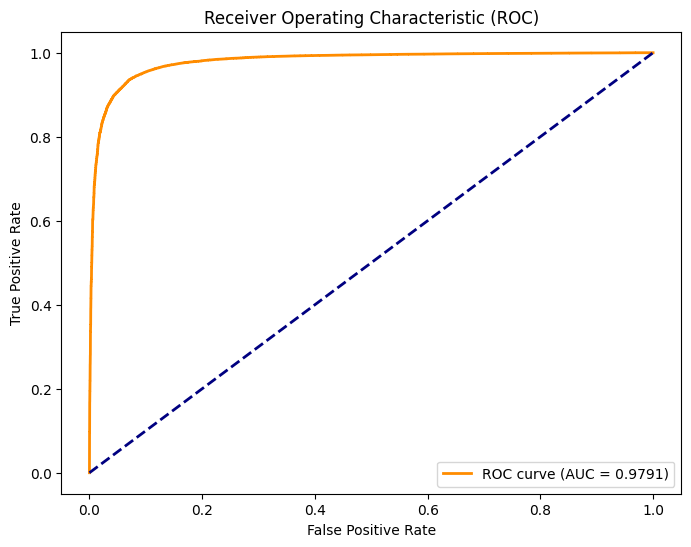

In [30]:
courbe_AUC(best_pipeline, X_test, y_test)
